In [23]:
import numpy as np
np.random.seed(10)
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomTreesEmbedding, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline

In [24]:
n_estimator = 10

In [25]:
X, y = make_classification(n_samples=80000, n_features=20)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)  # 将样本集分成测试集和训练集

**基本解释**

若不拆分，其中在使用数生成新特征样本的时候，会使用到label(target)标签，当再次使用新生成的样本特征进行训练的时候，此时的样本中加入了label信息。

In [41]:
X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train, y_train, test_size=0.5)  
# 再将训练集拆分成两个部分(GBDT/RF, LR), 这一步拆分主要是为了防止标签泄露

### 基于RF的监督变换

In [42]:
rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [43]:
## One-Hot编码
rf_enc = OneHotEncoder(categories='auto')

In [44]:
X_train_new_feature = rf.apply(X_train)

**解释**

10维的向量，是由10个决策树产生的，是一种stacking的方式。其中每一维向量中的每个值都是每颗树在叶子节点上的标记。

In [76]:
X_train_new_feature.shape, X_train.shape

((20000, 10), (20000, 20))

In [77]:
X_train_new_feature[0]

array([ 3, 11,  7,  9, 10,  3,  6,  3, 10, 10], dtype=int64)

In [46]:
X_train_new_feature_enc = rf_enc.fit(rf.apply(X_train))

In [47]:
X_train_new_feature_enc

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [48]:
rf_lm = LogisticRegression(solver='lbfgs', max_iter=1000)

In [49]:
rf_enc.transform(rf.apply(X_train_lr)).shape

(20000, 79)

In [50]:
rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [51]:
y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:,1]

In [53]:
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)

### 基于GBDT监督变换

In [54]:
grd = GradientBoostingClassifier(n_estimators=n_estimator)

In [55]:
grd.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=10,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [56]:
## 得到One-hot编码
grd_enc = OneHotEncoder(categories='auto')

In [58]:
grd.apply(X_train).shape

(20000, 10, 1)

In [59]:
grd_enc.fit(grd.apply(X_train)[:,:, 0])

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [60]:
grd_lm = LogisticRegression(solver='lbfgs', max_iter=1000)

In [61]:
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:,:,0]), y_train_lr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [62]:
y_pred_grd_lm = grd_lm.predict_proba(grd_enc.transform(grd.apply(X_test)[:,:,0]))[:,1]

In [64]:
fpr_grd_lm, tpr_grd_lm,_= roc_curve(y_test, y_pred_grd_lm)

### 使用GBDT进行预测

In [65]:
y_pred_grd = grd.predict_proba(X_test)[:, 1]

In [66]:
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)

### 直接使用RF进行预测

In [67]:
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

#### 直接使用LR进行预测

In [68]:
LR = LogisticRegression(n_jobs=4, C=0.1, penalty='l2')
LR.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=4, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [69]:
y_pred = LR.predict_proba(X_test)[:, 1]

In [70]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred)

### 画图

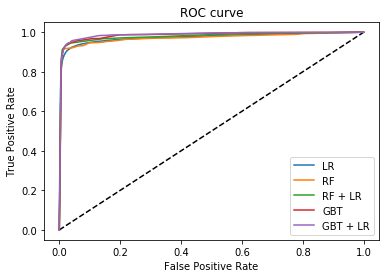

In [73]:

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')

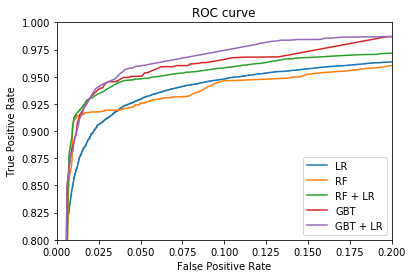

In [75]:
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()